## Assignment for Module 5, Training Models

**Cindy Lopes**

In this assignment you will train different models on a given data set, and find the one that performs best

### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [1]:
import os
import tarfile
from six.moves import urllib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
def plot_grid_cv_results(cv_results, title=None):
    '''
    Plots the train and test error for all the alphas tested during the cross validation grid search for
    Lasso and Ridge Regression.
    '''
    mean_test_scores = np.sqrt([score*-1 for score in cv_results['mean_test_score']])
    mean_train_score = np.sqrt([score*-1 for score in cv_results['mean_train_score']])
    
    alpha = [param['alpha'] for param in cv_results['params']]
    
    fig, ax = plt.subplots(ncols=2, figsize=(15,5))
    ax[0].plot(alpha, mean_train_score)
    ax[0].set_title('Train Error')
    ax[0].set_xlabel('Alpha')
    ax[0].set_ylabel('Mean Root Mean Square Error (Train)')
    
    ax[1].plot(alpha, mean_test_scores)
    ax[1].set_title('Test Error')
    ax[1].set_xlabel('Alpha')
    ax[1].set_ylabel('Mean Root Mean Square Error (Test)')
    
    fig.suptitle(title)

In [3]:
def plot_el_grid_cv_results(cv_results, l1_ratios, title=None):
    '''
    Similar to plot_grid_cv_results except also plots a separate line for each l1_ratio
    '''
    mean_test_scores = np.sqrt([score*-1 for score in cv_results['mean_test_score']])
    mean_train_score = np.sqrt([score*-1 for score in cv_results['mean_train_score']])
    params = cv_results['params']
    param_df = pd.DataFrame(params)

    fig, ax = plt.subplots(ncols=2, figsize=(15,5))
    for ratio in l1_ratios:
        indices = param_df[param_df['l1_ratio'] == ratio].index
        alphas = param_df[param_df['l1_ratio'] == ratio]['alpha']
        test_scores = mean_test_scores[indices]
        train_scores = mean_train_score[indices]

        ax[0].plot(alphas, train_scores)
        ax[1].plot(alphas, test_scores)

    ax[0].set_title('Train Error')
    ax[0].set_xlabel('Alpha')
    ax[0].set_ylabel('Mean Root Mean Square Error (Train)')
    ax[0].legend(l1_ratios)


    ax[1].set_title('Test Error')
    ax[1].set_xlabel('Alpha')
    ax[1].set_ylabel('Mean Root Mean Square Error (Test)')
    ax[1].legend(l1_ratios)

    fig.suptitle(title)

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [7]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [8]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [9]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [10]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


# ASSIGNMENT

### 1. Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [12]:
import numpy as np
np.random.seed(123)
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3)

### Features

In [13]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [14]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### 2. Polynomial transformations

Use PolynomialFeatures from sklearn.preprocessing

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly.fit(X_tr)
X_tr = poly.transform(X_tr)
X_te = poly.transform(X_te)

##### You should obtain X_tr and X_te with 136 columns each, since originally you had 15 features.

##### With m original features, the new added polynomial features of degree 2 are: $(m^2-m)/2+m+1$. Why?

**Answer**

PolynomialFeatures will add the constant 1 ($x^0 = 1$) which accounts for the $+1$

PolynomialFeatures with degree of 2 will add a new feature that is square of each of the features which accounts for the  $+m$.

Lastly it will add all the combinations of the features less than degree to, this accounts for $(m^2-m) / 2$.

So $(m^2-m)/2+m+1$ = (num_combination_features) + (num_features_squared) + 1


##### These, plus the original features gives a total of  $(m^2-m)/2+2m+1$

In [16]:
print("Original number of features: "+str(len(features)))
print("Final number of features: "+str(X_tr.shape[1]))

Original number of features: 15
Final number of features: 136


### 3. Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(2)
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

#### Comparing models

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### 4. Linear regression on original features (no transformations) --- benchmark

#### Your goal is to find the model that minimizes the rmse score

In [19]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [68447.82279847 69777.52395334 68778.95097477 68915.51212139]
Mean: 68979.95246199463


### 5. Linear regression  (on transformed features: polynomial transformation + scaling)

Now do as in 4 but with the original and transformed features (136 features)

In [20]:
from sklearn.linear_model import LinearRegression
lin_trans_scores = cross_val_score(LinearRegression(), X_tr, y_tr, scoring="neg_mean_squared_error", cv=4)
lin_trans_rmse_scores = np.sqrt(-lin_trans_scores)
display_scores(lin_trans_rmse_scores)

Scores: [3.95104797e+13 6.25732389e+04 6.17242634e+04 7.36721007e+13]
Mean: 28295645148582.94


If the error on the cross-validation is too high it is because the model is over-fitting. Regularization is needed.

### 6. Ridge regression

In [21]:
alphas = [0.001,0.01,0.1,1,10, 450, 500, 550, 600, 650, 700, 750, 800, 999, 1000, 2000, 5000]

In [22]:
from sklearn.linear_model import Ridge
param_grid = [{'alpha': alphas}]
grid_search_rr = GridSearchCV(Ridge(), 
                              param_grid, 
                              cv=3, 
                              scoring='neg_mean_squared_error',
                             return_train_score=True)
grid_search_rr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 450, 500, 550, 600, 650, 700, 750, 800, 999, 1000, 2000, 5000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

{'alpha': 750}


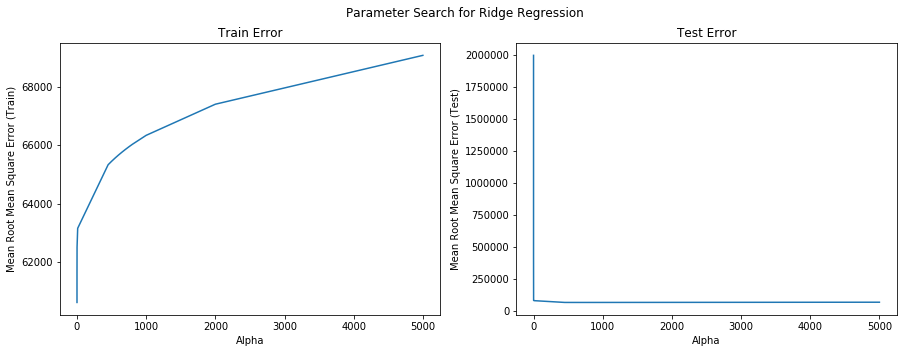

In [23]:
print(grid_search_rr.best_params_)
plot_grid_cv_results(grid_search_rr.cv_results_, "Parameter Search for Ridge Regression")

In [24]:
print(np.sqrt(-grid_search_rr.best_score_))

67665.70873057682


### 7. Lasso regression

Now do the same as in 6 but with Lasso

In [25]:
from sklearn.linear_model import Lasso
param_grid = [{'alpha': alphas}]
grid_search_lr = GridSearchCV(Lasso(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_lr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 450, 500, 550, 600, 650, 700, 750, 800, 999, 1000, 2000, 5000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [26]:
print(grid_search_lr.best_params_)
grid_search_lr.cv_results_['mean_train_score']

{'alpha': 500}


array([-3.97402907e+09, -3.97403055e+09, -3.97404703e+09, -3.97429619e+09,
       -3.98548193e+09, -4.25738708e+09, -4.28059058e+09, -4.30070451e+09,
       -4.31725710e+09, -4.33362902e+09, -4.35004961e+09, -4.36847581e+09,
       -4.38577086e+09, -4.44732578e+09, -4.44758027e+09, -4.68140711e+09,
       -5.07319511e+09])

{'alpha': 500}


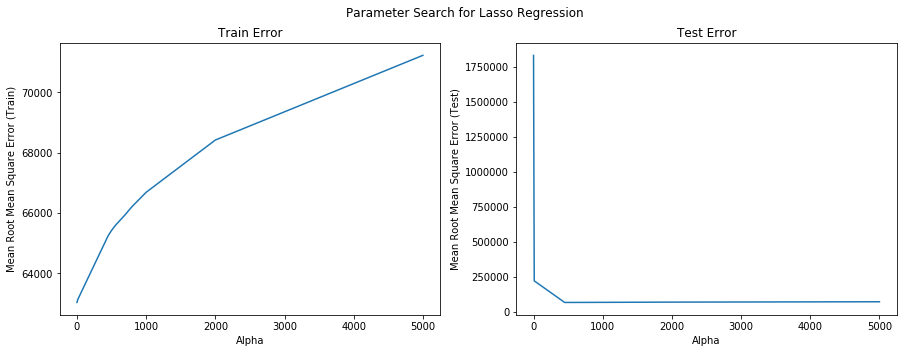

In [27]:
print(grid_search_lr.best_params_)
plot_grid_cv_results(grid_search_lr.cv_results_, "Parameter Search for Lasso Regression")

In [28]:
print(np.sqrt(-grid_search_lr.best_score_))

66414.33392313564


### 8. Elastic Net regression

Do the same as in 6 and 7, but now with Elastic Net. However, the grid search should be over the parameters alpha and  l 1ratio. Use just 3 values for l1_ratio.

In [29]:
from sklearn.linear_model import ElasticNet
# In addition to alpha let's also iterate over the l1 ratios
l1_ratios = [0, 0.5, 1]
param_grid = [{'alpha': alphas, 'l1_ratio': l1_ratios}]
grid_search_enr = GridSearchCV(ElasticNet(), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_enr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 450, 500, 550, 600, 650, 700, 750, 800, 999, 1000, 2000, 5000], 'l1_ratio': [0, 0.5, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

{'alpha': 500, 'l1_ratio': 1}


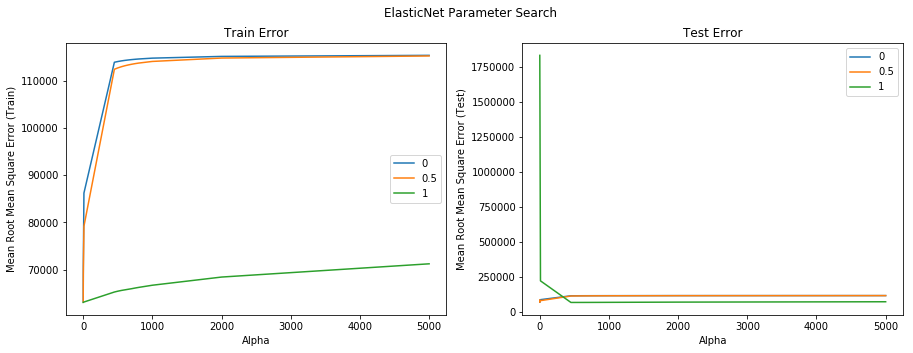

In [30]:
print(grid_search_enr.best_params_)
plot_el_grid_cv_results(grid_search_enr.cv_results_, l1_ratios, 'ElasticNet Parameter Search')

In [31]:
print(np.sqrt(-grid_search_enr.best_score_))

66414.33392313564


In [32]:
print(np.sqrt(-grid_search_rr.best_score_))
print(np.sqrt(-grid_search_lr.best_score_))
print(np.sqrt(-grid_search_enr.best_score_))

67665.70873057682
66414.33392313564
66414.33392313564


#### Observations

It appears **Lasso** Regression performed based with a root square mean error of *66414.33*. The best model also had an *alpha* of 500 which was in the middle of the tested alphas.

An interesting observation was **Elastic Net Regression** best parameters were *l1_ratio* of 1 and *alpha* of 500. This is the same model as the best Lasso Regresion.


### Evaluating your best model on TESTING data

Choose among grid_search_rr, grid_search_lr, and grid_search_enr, the model with best performance

In [33]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_lr.best_estimator_   ## grid_search SHOULD BE THE BEST GRID SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

65052.448434888276


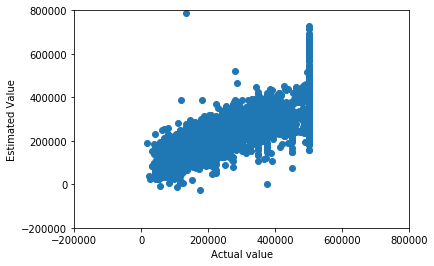

In [34]:
import matplotlib.pyplot as plt

plt.scatter(x=y_te, y=y_te_estimation)
plt.xlabel("Actual value")
plt.ylabel('Estimated Value')
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

In [35]:
df = pd.DataFrame([final_model.coef_, poly.get_feature_names()]).T
df.columns=['Coef', 'Feature Name']
dropped_features = df[pd.isnull(df['Coef'])]
df = df[~pd.isnull(df['Coef'])]
df['Absolute Coef'] = np.abs(df['Coef'])
df = df.drop(['Coef'], axis=1)
non_zero_coef = df[df['Absolute Coef'] != 0]
non_zero_coef = non_zero_coef.sort_values(by='Absolute Coef', ascending=False)
non_zero_coef.head(10)

,Feature Name,Absolute Coef
23,x0 x7,42938.3
31,x1^2,39101.3
1,x0,36298.1
48,x2 x5,27637.7
8,x7,23266.4
84,x5 x8,22535.4
47,x2 x4,21465.2
49,x2 x6,19728.2
73,x4 x7,13904.3
13,x12,13888.9


Interesting many of the features with the highest absolute coefficient are the combination features.

### Linear Regression on Untransformed Data

Let's compare against a Linear Regression trained against the un-transformed data

In [36]:
final_model = LinearRegression().fit(train_set[features], train_set[target])   ## grid_search SHOULD BE THE BEST GRID SEARCH ##

y_te_estimation = final_model.predict(test_set[features])

final_mse = mean_squared_error(test_set[target], y_te_estimation)
final_rmse = np.sqrt(final_mse)
print("Final Root Square Mean Error for Linear Regression on Untransformed Data: \n{}".format(final_rmse))

Final Root Square Mean Error for Linear Regression on Untransformed Data: 
68306.9529933634


### Question: Before you computed the final_rmse on the test data, what was your expected value for this quantity? Does your best model have high variance?

**Answer:**

Before testing on the testing data the model I wasn't sure the model would perform particularly well since the best score was only 66414.33 (compare to 68306.95 of linear regression on untransformed data).

However when tested on the test data the best rmse was actually 65052.45 which was even better than the best score on the training data indicating that the model did generalize well to the rest of the data set better than expected.

Given the model performed better on the training data and ended up with a fairly high *alpha* the best model **did not** have high variance because it did not overfit to the training data.

#[Optional]
Why does the matrix X appears transponsed in the normal equation in the linear regression? Equation 4.4. Start from equation 4.3



The normal equation was calculated by taking the partial derivative of the cost function (Equation 4.3) and setting them it to 0.

If X is a m x n matrix

$\theta = (X^T X)^{-1} . X^t . y$

$(X^T X)^{-1}$ = n x n

$X^t . y$ = (n x m) (m * 1) = n x 1

(n x n) . (n x 1) = (n x 1) --> Dimension of  $\theta $




#[Optional]
Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?



**Answer**:

This depends particularly on the optimization problem.

If the optimization problem has local mimimums Batch Gradient Descent and Mini Batch Gradient Descent may get stuck in them while Stochastic Gradient Descent may have a better chance of escaping. 

If the optimization problem is convex the learning rate for Mini Batch and Stochastic Gradient Descent will need to be slowly reduced (Annealing) or they may never converge.

The models may be very similar but not identical.

#[Optional]
Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?



**Answer:**

**No**, due to the stochastic nature of Mini-Batch Gradient Descent you don't have any guarentees that training on more data will result in an increase or decrease performance so unlike Batch Gradient Descent where you can stop early after a certain number of epochs with Mini-Batch Gradient Descent you may not reach a minimum.

#[Optional]
Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?



**Answer:**

I would say the model suffers from high **bias** because it is underfitting both the training the test data.

You should __decrease__ α alpha so the model is less regularized/more complicated and can potentially better fit both steps

#[Optional]
Why does the matrix X appears transponsed in the normal equation in the linear regression? Equation 4.4. Start from equation 4.3

See early question
